<a href="https://colab.research.google.com/github/adarshmodh/Deep-Learning-Projects/blob/master/Karpathy_nanoGPT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

print("length of dataset in characters: ", len(text))

--2025-11-11 21:46:35--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt’

input.txt           100%[===================>]   1.06M  --.-KB/s    in 0.03s   

2025-11-11 21:46:35 (34.5 MB/s) - ‘input.txt’ saved [1115394/1115394]

length of dataset in characters:  1115394


In [ ]:
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [ ]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [ ]:
# create a mapping from characters to integers - Vanilla Tokenizer (google uses sentencepiece, openai uses tiktoken)
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [ ]:
import tiktoken
enc = tiktoken.get_encoding("gpt2") #subword tokenizer
print(enc.n_vocab)
print(enc.encode("hii there"))

50257
[71, 4178, 612]


In [ ]:
# let's now encode the entire text dataset and store it into a torch.Tensor
import torch # we use PyTorch: https://pytorch.org
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

In [ ]:
# split into train and validation sets

n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

In [ ]:
block_size = 8 # aka context length
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [ ]:
x = train_data[:block_size]
y = train_data[1:block_size+1]

for t in range(block_size):
  context = x[:t+1]
  target = y[t]
  print(f" input is {context}, the target is {target}")

 input is tensor([18]), the target is 47
 input is tensor([18, 47]), the target is 56
 input is tensor([18, 47, 56]), the target is 57
 input is tensor([18, 47, 56, 57]), the target is 58
 input is tensor([18, 47, 56, 57, 58]), the target is 1
 input is tensor([18, 47, 56, 57, 58,  1]), the target is 15
 input is tensor([18, 47, 56, 57, 58,  1, 15]), the target is 47
 input is tensor([18, 47, 56, 57, 58,  1, 15, 47]), the target is 58


In [ ]:
### Dataloader
# torch.manual_seed(1337)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    idx = torch.randint(len(data) - block_size, (batch_size,))      # generate random indices from 0 and (len(data)- block_size) with batch_size offsets between them
    x = torch.stack([data[i:i+block_size] for i in idx])
    y = torch.stack([data[i+1:i+block_size+1] for i in idx])
    x, y = x.to(device), y.to(device)
    return x,y

xb, yb = get_batch('train')
print(f'inputs: {xb.shape}\n {xb},\ntargets: {yb.shape}\n{yb} \n')

for b in range(batch_size):    # batch dimension
  for t in range(block_size):   # block or time dimension
    context = xb[b, :t+1]
    target = yb[b, t]
    print(f" input is {context}, the target is {target}")

inputs: torch.Size([4, 8])
 tensor([[57, 53,  6,  0, 32, 53,  1, 51],
        [59, 11,  1, 58, 46, 43, 56, 43],
        [39, 52, 42, 11,  1,  5, 58, 47],
        [43, 60, 43, 56,  1, 58, 47, 50]], device='cuda:0'),
targets: torch.Size([4, 8])
tensor([[53,  6,  0, 32, 53,  1, 51, 39],
        [11,  1, 58, 46, 43, 56, 43, 44],
        [52, 42, 11,  1,  5, 58, 47, 57],
        [60, 43, 56,  1, 58, 47, 50, 50]], device='cuda:0') 

 input is tensor([57], device='cuda:0'), the target is 53
 input is tensor([57, 53], device='cuda:0'), the target is 6
 input is tensor([57, 53,  6], device='cuda:0'), the target is 0
 input is tensor([57, 53,  6,  0], device='cuda:0'), the target is 32
 input is tensor([57, 53,  6,  0, 32], device='cuda:0'), the target is 53
 input is tensor([57, 53,  6,  0, 32, 53], device='cuda:0'), the target is 1
 input is tensor([57, 53,  6,  0, 32, 53,  1], device='cuda:0'), the target is 51
 input is tensor([57, 53,  6,  0, 32, 53,  1, 51], device='cuda:0'), the target is

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.manual_seed(1337)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200

class BigramLanguageModel(nn.Module):
  def __init__(self, vocab_size):
    super().__init__()
    # each token directly reads off the logits for the next token from a lookup table
    self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

  def forward(self, idx, targets=None):
    # idx and targets are both (B,T) tensor of integers
    logits = self.token_embedding_table(idx) # scores for the next character - (B,T,C) - batch, block (time), channel

    if targets is None:
      loss = None
    else:
      B, T, C = logits.shape
      logits = logits.view(B*T, C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)
    return logits, loss

  def generate(self, idx, max_new_tokens):
    # idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):
      # get the predictions
      logits, loss = self(idx)
      # focus only on the last time step - thats what the prediction is going to be
      logits = logits[:, -1, :] # becomes (B, C) - pluck out last T
      # apply softmax to get probabilities
      probs = F.softmax(logits, dim=-1) # (B, C)
      # sample from the distribution - gives one sample
      idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
      # append sampled index to the running sequence - of max_new_tokens
      idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
    return idx

m = BigramLanguageModel(vocab_size)
model = m.to(device)
logits, loss = model(xb, yb)
print(logits.shape, loss.item()) # 65 is vocab_size

zeros_idx = torch.zeros((1, 1), dtype=torch.long, device=device) # the zeroth char in the vocab is new line which is reasonable for sending first
print(decode(model.generate(zeros_idx, max_new_tokens=100)[0].tolist()))


torch.Size([32, 65]) 4.518858909606934

pYCXxfRkRZd
wc'wfNfT;OLlTEeC K
jxqPToTb?bXAUG:C-SGJO-33SM:C?YI3a
hs:LVXJFhXeNuwqhObxZ.tSVrddXlaSZaNe


In [ ]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()  # not effective for this model because no dropout or batchnorm layers are present
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)
batch_size = 32
max_iters = 3000
eval_interval = 300

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())

step 0: train loss 4.2369, val loss 4.2340
step 300: train loss 2.5006, val loss 2.5209
step 600: train loss 2.4813, val loss 2.4928
step 900: train loss 2.4712, val loss 2.4896
step 1200: train loss 2.4330, val loss 2.4545
step 1500: train loss 2.4252, val loss 2.4455
step 1800: train loss 2.4231, val loss 2.4558
step 2100: train loss 2.4240, val loss 2.4596
step 2400: train loss 2.4170, val loss 2.4247
step 2700: train loss 2.4134, val loss 2.4153
2.5119681358337402


In [ ]:
print(decode(model.generate(torch.zeros((1, 1), dtype=torch.long, device=device), max_new_tokens=500)[0].tolist()))


Th fepyotssthecas l.
TAnEn s wethal wove.
se ed Pe bene oveveaimous?



AMPe cok hedin tie s inds he be feRUCatos:
Whit Clo ghasundisthou ldu I fo, moxcone.

Anthatakes aghercobun ws m k s withoumas Fond the wlld INour id, mersed
Fourd?
TI idurd po venond, d Cadity
K:
BIUSoou tiund thornofen e sutan wiporthare whanot, sitthers, spe Bllellke, on s h O, t pan, ce wat d tive wout ir f; u;

Fekeen oueee rtano iru forealoiroret HEnk;
CKES:MO tck in, d cer t ftanofallon bay ho s, andemen, meseveminds 


# The mathematical trick in self-attention (matrix multiplication for weighted aggregation)


In [ ]:
# how to make the 8 tokens (block_size aka context length) to talk to each other
torch.manual_seed(1337)
B,T,C = 4,8,2 # batch, time, channels
x = torch.randn(B,T,C)
x.shape


torch.Size([4, 8, 2])

In [ ]:
# we want x[b ,t] = mean_{i<=t} x[b,i] - First option to get some attention is averaging all the tokens before it

xmean = torch.zeros((B, T, C))
for b in range(B):
  for t in range(T):
    xprev = x[b, :t+1] # (t, C)
    xmean[b, t] = torch.mean(xprev, 0)

print(x[0], xmean[0])

tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]]) tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])


In [ ]:
print(torch.tril(torch.ones(3, 3)))

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])


In [ ]:
# toy example illustrating how matrix multiplication can be used for a "weighted aggregation"
torch.manual_seed(42)
a = torch.tril(torch.ones(3, 3))
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print('a=')
print(a)
print('--')
print('b=')
print(b)
print('--')
print('c=')
print(c)

a=
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
--
b=
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
--
c=
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])


In [ ]:
# going back to the previous example, version 2 - to do weighted aggregation

wei = torch.tril(torch.ones(T, T))
wei = wei / wei.sum(1, keepdim=True)

xmean2 = wei @ x # (B, T, T) @ (B, T, C) ----> (B, T, C)

print(xmean2)

tensor([[[ 0.1808, -0.0700],
         [-0.0894, -0.4926],
         [ 0.1490, -0.3199],
         [ 0.3504, -0.2238],
         [ 0.3525,  0.0545],
         [ 0.0688, -0.0396],
         [ 0.0927, -0.0682],
         [-0.0341,  0.1332]],

        [[ 1.3488, -0.1396],
         [ 0.8173,  0.4127],
         [-0.1342,  0.4395],
         [ 0.2711,  0.4774],
         [ 0.2421,  0.0694],
         [ 0.0084,  0.0020],
         [ 0.0712, -0.1128],
         [ 0.2527,  0.2149]],

        [[-0.6631, -0.2513],
         [ 0.1735, -0.0649],
         [ 0.1685,  0.3348],
         [-0.1621,  0.1765],
         [-0.2312, -0.0436],
         [-0.1015, -0.2855],
         [-0.2593, -0.1630],
         [-0.3015, -0.2293]],

        [[ 1.6455, -0.8030],
         [ 1.4985, -0.5395],
         [ 0.4954,  0.3420],
         [ 1.0623, -0.1802],
         [ 1.1401, -0.4462],
         [ 1.0870, -0.4071],
         [ 1.0430, -0.1299],
         [ 1.1138, -0.1641]]])


In [ ]:
# version 3 softmax

tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))   ##all the elements where tril is zero, make it '-inf'
wei = F.softmax(wei, dim=-1)
xmean3 = wei @ x
torch.allclose(xmean, xmean3) # should be true

False

In [ ]:
# version 4 self attention (single head)
# how to make the 8 tokens (block_size aka context length) to talk to each other - affinity between tokens
# every single token will emit 2 vectors - query vector (what am i looking for), key vector (what do i contain)
# to get affinities = dot product of all keys and queries = wei

torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# lets see a single head perform self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)  # (B,T,16)
q = query(x) # (B,T,16)

wei = q @ k.transpose(-2, -1) # # (B, T, 16) @ (B, 16, T) ---> (B, T, T) (transpose last two dimensions)

tril = torch.tril(torch.ones(T, T))
# this is a decoder block and future tokens will not talk to past tokens because they can give away the answer,
#which is why we do masking
wei = wei.masked_fill(tril == 0, float('-inf'))   ##all the elements where tril is zero, make it '-inf'
wei = F.softmax(wei, dim=-1)

v = value(x)  # value vector - aggregated information from input x
out = wei @ v
out.shape

torch.Size([4, 8, 16])


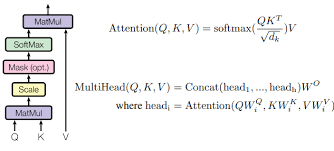



Notes:
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
- There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
For example - convolutions have a notion of space by design
- Each example across batch dimension is of course processed completely independently and never "talk" to each other
- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling. This is a decoder block and future tokens will not talk to past tokens because they can give away the answer, which is why we do masking
- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Otherwise the wei numbers will have a higher variance and softmax will saturate the weights too much and will act as one-hot which will only activate some of the weights.

In [ ]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1) #* head_size**-0.5
print(k.var(), q.var(), wei.var())

tensor(0.9006) tensor(1.0037) tensor(15.9317)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# torch.manual_seed(1337)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 32

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size))) # this is not a parameter, so pytorch convention is define it as buffer

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])

        ## added later
        self.proj = nn.Linear(n_embd, n_embd)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.proj(out)
        return out

class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity - check the paper Attention is all you need"""

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)

    def forward(self, x):
        x = self.sa(x)
        x = self.ffwd(x)
        return x

class BigramLanguageModel(nn.Module):
  def __init__(self, vocab_size):
    super().__init__()
    # each token directly reads off the logits for the next token from a lookup table
    self.token_embedding_table = nn.Embedding(vocab_size, n_embd) ## a linear layer not direct embedding
    self.position_embedding_table = nn.Embedding(block_size, n_embd) #block size is context length

    # Single head self-attention
    # self.sa_head = Head(n_embd)

    # Multi-head self-attention with feedforward (linear layer with non-linearity)
    self.sa_head = MultiHeadAttention(4, n_embd//4) #i.e 4 heads of 8-dim self-attention, so n_embds is still 32
    self.ffwd = FeedForward(n_embd)

    # Transformer blocks with skip connections
    self.blocks = nn.Sequential(
        Block(n_embd, n_head=4),
        Block(n_embd, n_head=4),
        Block(n_embd, n_head=4),
        # nn.LayerNorm(n_embd), # final layer norm before the final linear layer
    )

    self.lm_head = nn.Linear(n_embd, vocab_size)

  def forward(self, idx, targets=None):
    B,T = idx.shape
    # idx and targets are both (B,T) tensor of integers

    tok_emb = self.token_embedding_table(idx) # (B,T,C)
    pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
    x = tok_emb + pos_emb # (B,T,C). - holds position and identities of these tokens
    # x = self.sa_head(x)
    x = self.blocks(x)
    x = self.ffwd(x)  # (B, T, C)
    logits = self.lm_head(x) # (B,T,vocab_size)

    if targets is None:
      loss = None
    else:
      B, T, C = logits.shape
      logits = logits.view(B*T, C)
      targets = targets.view(B*T)
      loss = F.cross_entropy(logits, targets)
    return logits, loss

  def generate(self, idx, max_new_tokens):
    # idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):
      # get the predictions
      logits, loss = self(idx[:, -block_size:])
      # focus only on the last time step - thats what the prediction is going to be
      logits = logits[:, -1, :] # becomes (B, C) - pluck out last T
      # apply softmax to get probabilities
      probs = F.softmax(logits, dim=-1) # (B, C)
      # sample from the distribution - gives one sample
      idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
      # append sampled index to the running sequence - of max_new_tokens
      idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
    return idx

m = BigramLanguageModel(vocab_size)
model = m.to(device)
logits, loss = model(xb, yb)
print(logits.shape, loss.item()) # 65 is vocab_size

zeros_idx = torch.zeros((1, 1), dtype=torch.long, device=device) # the zeroth char in the vocab is new line which is reasonable for sending first
# print(decode(model.generate(zeros_idx, max_new_tokens=100)[0].tolist()))

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()  # not effective for this model because no dropout or batchnorm layers are present
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# create a PyTorch optimizer

batch_size = 32
max_iters = 5000
eval_interval = 300
lr = 1e-3
optimizer = torch.optim.AdamW(model.parameters(), lr)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())

torch.Size([256, 65]) 4.26030969619751
step 0: train loss 4.2520, val loss 4.2472
step 300: train loss 2.5132, val loss 2.5437
step 600: train loss 2.3893, val loss 2.3995
step 900: train loss 2.3050, val loss 2.3259
step 1200: train loss 2.2692, val loss 2.2751
step 1500: train loss 2.2297, val loss 2.2424
step 1800: train loss 2.1875, val loss 2.2237
step 2100: train loss 2.1879, val loss 2.2117
step 2400: train loss 2.1510, val loss 2.1781
step 2700: train loss 2.1363, val loss 2.1751
step 3000: train loss 2.1249, val loss 2.1770
step 3300: train loss 2.1104, val loss 2.1573
step 3600: train loss 2.0891, val loss 2.1420
step 3900: train loss 2.0834, val loss 2.1539
step 4200: train loss 2.0681, val loss 2.1365
step 4500: train loss 2.0555, val loss 2.1210
step 4800: train loss 2.0386, val loss 2.1267
2.0856590270996094


In [ ]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))



Seare willafturs:
And whorf?
BRIV:
Hy God deparse, Bery hast Go ah my of By rest har I or glemer hatile! CoThal that to you with Thou do diso rest hight cart but up ancif agars rishn

Well was it the mure to spulids cany mever it wore ladow fall fath and tron the wrow a what to grere with a Pagch?

QUES:
In to of lod.

ARDUTIO:
He and ho' apo, good the carcegatexpobloning thand of but lid!

HAMBOLIIZALNIO:
Treal is naeffer orsp youn sand what ad vingess agenst go you, hear! save the mast Go mady of meart lay BLy nevem grorws loving end hard in an his the her and leeven or retary.

PONIUTIO:
He hady not
Mearrath of makand to scunith holiss honow So ear Dor was reIS Buted, Hid fexind re; jeop wor thiqutting;
In afterguece!
Hers him?
Hencourter or you cont; the Way
Sids theart for wout thou hede thou cought the wan with wick: wor in in tough park me wrat of quen So me a demelt in will thy we frrpuon the reat I charn must grando bese dearm liky, know Ror nots his beins
Himan!'t and seees,

In [ ]:
class LayerNorm1d: # (used to be BatchNorm1d, no need for running buffers, no momentum, no differences during train/test)

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

  def __call__(self, x):
    # calculate the forward pass
    xmean = x.mean(1, keepdim=True) # batch mean (instead of normalizing columns, we normalize rows)
    xvar = x.var(1, keepdim=True) # batch variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

In [ ]:
# added layernorms and skip (residual connections)
class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.layernorm(n_embd)
        self.ln2 = nn.layernorm(n_embd)

    def forward(self, x):
        # x = x + self.sa(x)  # this line basically implements a skip connection in the forward pass
        # x = x + self.ffwd(x) # this line basically implements a skip connection in the forward pass

        x = x + self.sa(self.ln1(x))  # this line basically implements a skip connection in the forward pass
        x = x + self.ffwd(self.ln2(x)) # this line basically implements a skip connection in the forward pass
        return x


### Full finished code, for reference

You may want to refer directly to the git repo instead though.

Note - what we have implemented is only a decoder block (right side in the image), we dont have an encoder block and cross attention. We only have a decoder because we are randomly generating text from a model that has learnt from a dataset. (the tril mask gives it an autoregressive property that lets it just sample from the model)
An encoder-decoder arch like mentioned in the paper is for machine translation.

The way it works - output from the encoder is brought in through cross attention to the decoder (mult-head attention) block. The queries are generated from X, but the keys and values are still generated from the encoder
So the decoder is conditioned not only on the past, but the information that comes in from the encoder (which has seen the full french text)

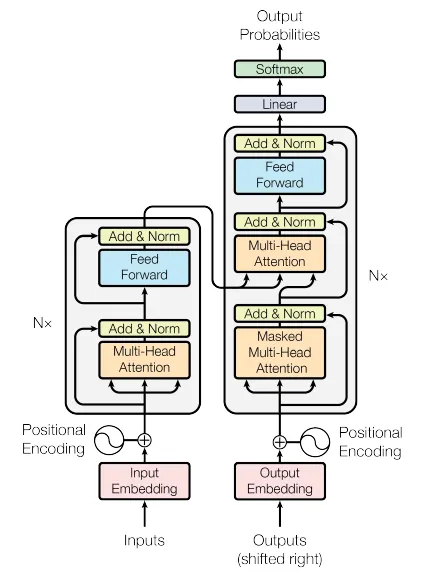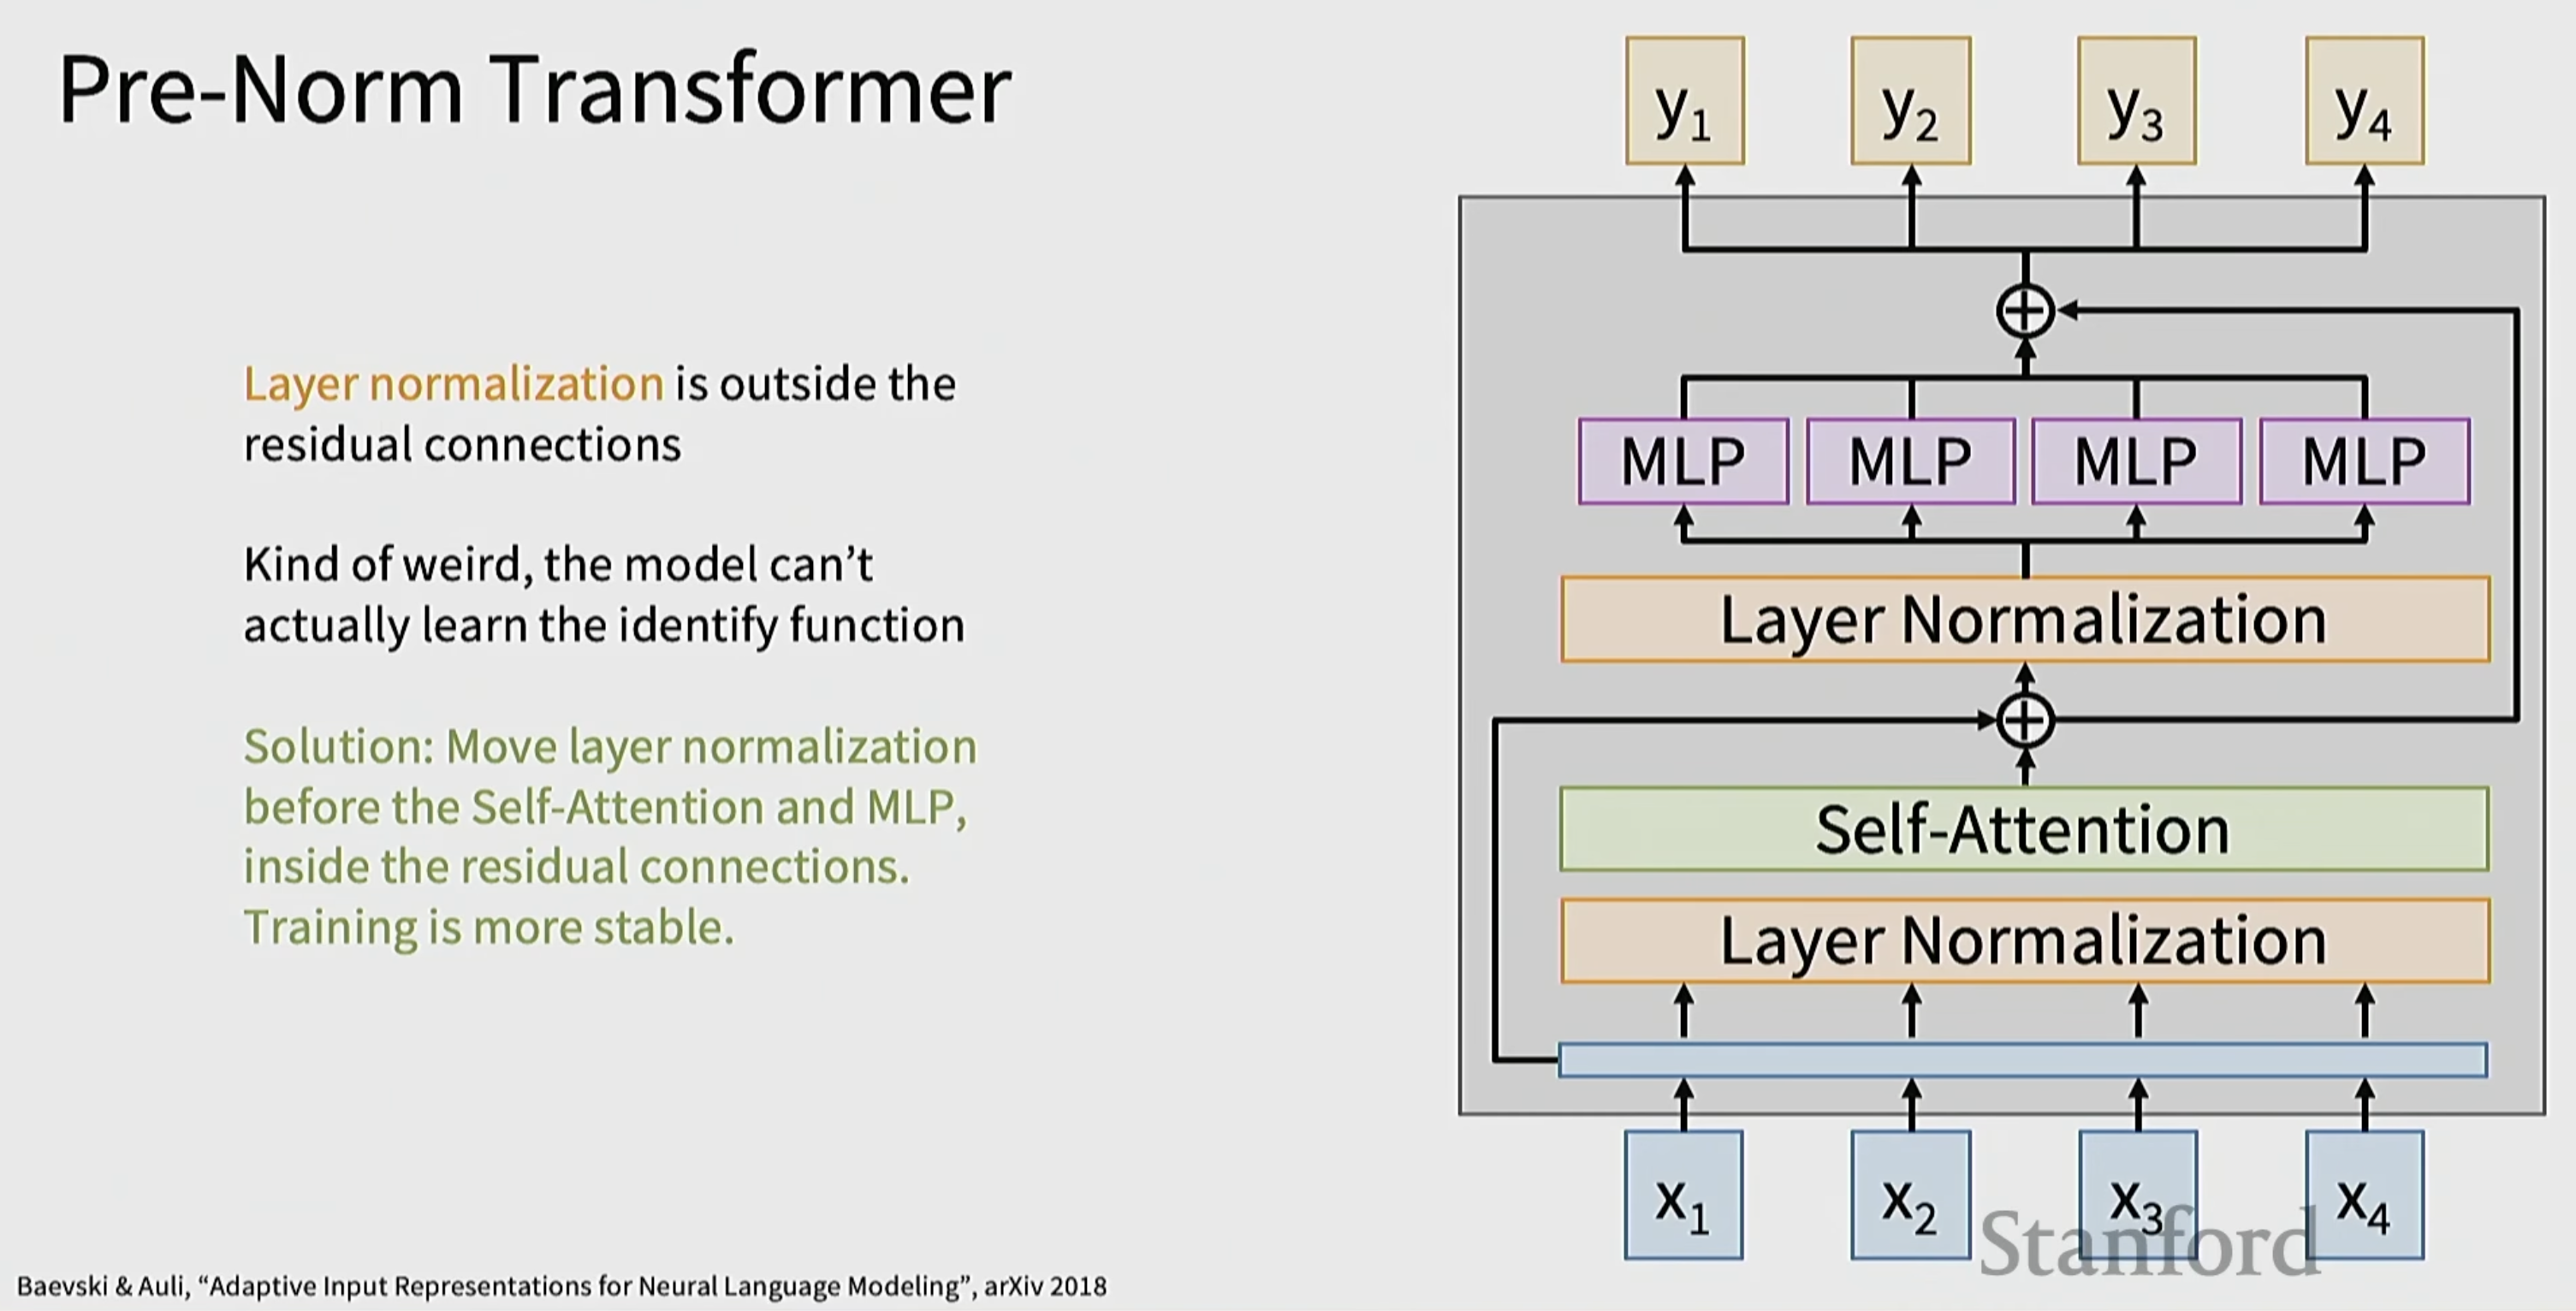


In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 64 # how many independent sequences will we process in parallel?
block_size = 256 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6 # number of blocks
dropout = 0.2
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size))) # this is not a parameter, so pytorch convention is define it as buffer

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


10.788929 M parameters
step 0: train loss 4.2849, val loss 4.2823
step 100: train loss 2.4585, val loss 2.4788
step 200: train loss 2.3426, val loss 2.3912
step 300: train loss 2.0551, val loss 2.1426
step 400: train loss 1.8359, val loss 1.9604
step 500: train loss 1.6761, val loss 1.8353
step 600: train loss 1.5668, val loss 1.7468
step 700: train loss 1.4915, val loss 1.6832
step 800: train loss 1.4341, val loss 1.6422
step 900: train loss 1.3870, val loss 1.6016
step 1000: train loss 1.3482, val loss 1.5758
step 1100: train loss 1.3183, val loss 1.5503
step 1200: train loss 1.2934, val loss 1.5348
step 1300: train loss 1.2705, val loss 1.5207
step 1400: train loss 1.2459, val loss 1.5125
step 1500: train loss 1.2316, val loss 1.5127
step 1600: train loss 1.2136, val loss 1.5036
step 1700: train loss 1.1965, val loss 1.4940
step 1800: train loss 1.1826, val loss 1.4896
step 1900: train loss 1.1643, val loss 1.4782
step 2000: train loss 1.1514, val loss 1.4734
step 2100: train loss 1